# Problem Description

This project's objective is to cluster patients with a heart disease diagnosis based on their similar characteristics. This outcome can be used to help medical professionals determine if there are ways to identify the treatments that will be more suitable to patients within the same groups. They can also use the patient clusters to further research if if there are other suitable treatments that could be used for a patient in the group, if the other patients in the group have responded well to the treatment already.

The data is sourced from the Kaggle competition **"K-Means Clustering for Heart Disease Analysis"** (https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis/data ). This data was collected from a medical center in California.

This project uses exploratory data analysis (EDA) and supervised learning to predict the probability of a flood occuring. This project uses the regression supervised learning model.
* **Link to GitHub repo of this project**: https://github.com/squpen/unsupervisedML

In [124]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score # Note: confusion matrix and accuracy score is not be used in this problem, as the data is not labeled
import seaborn as sns
import time

# EDA Procedure

**Cleaning the Data**

As shown below, the dataset has a **size of 920 entries (107.9KB), with 14 rows**. The data will be inspected to confirm if any cleaning is required to:
* Remove invalid values
* Correct data types
* Handle null values
* Additionally, if there is categorical features, they may need to be converted using one-hot encodings or another method in order to use them in unsupervised clustering algorithms

In [20]:
# load data from csv
df = pd.read_csv('heart_disease.csv')

In [5]:
# display data characterstics
print(df.head())
print(df.info())
df.describe()

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   0   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   1   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   2   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   3   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   4   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca               thal  
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0       fixed defect  
1  lv hypertrophy   108.0   True      1.5         flat  3.0             normal  
2  lv hypertrophy   129.0   True      2.6         flat  2.0  reversable defect  
3          normal   187.0  False      3.5  downsloping  0.0             normal  
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0             normal  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 9

,id,age,trestbps,chol,thalch,oldpeak,ca
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000
mean,459.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653
min,0.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,229.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000
50%,459.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000
75%,689.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000
max,919.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000


In [6]:
# check for null values
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


As the data size is 920, removing the null values in thal(a blood disorder) - 486 entries, ca(number of major vessels) - 611 entries, and slope (slope of peak esercise ST segment) - 309 entries, would significantly reduce the available data size. Instead, use average value to populate the null values of numerical features.

For features that are categorical, replace null witht the most common value used.

In [33]:
# clean null values from data, without significantly reducing available data size

df.replace('', np.nan, inplace=True) # replace any blank values with N/A, so that they can be filled

# use mean values for numerical features, and the mode (most common non-null category) for categorical features
df['trestbps'] = df['trestbps'].fillna(df['trestbps'].mean())
df['chol'] = df['chol'].fillna(df['chol'].mean())
df['fbs'] = df['fbs'].fillna(df['fbs'].mode()[0])
df['restecg'] = df['restecg'].fillna('normal')
df['thalch'] = df['thalch'].fillna(df['thalch'].mean())
df['exang'] = df['exang'].fillna(df['exang'].mode()[0])
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].mean())
df['slope'] = df['slope'].fillna('flat')
df['ca'] = df['ca'].fillna(df['ca'].mean())
df['thal'] = df['thal'].fillna("normal")

/tmp/ipython-input-718127419.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['exang'] = df['exang'].fillna(df['exang'].mode()[0])


In [34]:
# verify no more null values
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0


In [35]:
# convert categorical variables to type categorical
df['sex'] = df['sex'].astype('category')
df['dataset'] = df['dataset'].astype('category')
df['thal'] = df['thal'].astype('category')
df['slope'] = df['slope'].astype('category')
df['cp'] = df['cp'].astype('category')
df['fbs'] = df['fbs'].astype('category')
df['restecg'] = df['restecg'].astype('category')
df['exang'] = df['exang'].astype('category')

         sex    dataset            cp    fbs restecg  exang slope    thal
count    920        920           920    920     920    920   920     920
unique     2          4             4      2       3      2     3       3
top     Male  Cleveland  asymptomatic  False  normal  False  flat  normal
freq     726        304           496    782     553    583   654     682

    id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   0   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   1   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   2   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   3   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   4   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca               thal  
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0       fixed defect  
1  lv hypertrophy   1

**Describe and Inspect the Data**
* Show counts and common values of each feature
* Inspect distribution between classes
* Inspect number of features and use correlation matrix to determine if there is possibility that some features are more informative than others. If yes, there is potential that feature engineering can help effectively reduce the dimensionality of the data.

In [40]:
#display summary of numerical features
print(df.describe())

#display most common values in each category
print("----------------------\n", df.describe(include='category'))

# view sample rows
print("----------------------\n", df.head())

               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  920.000000  920.000000  920.000000  920.000000   
mean   459.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   18.443895  108.957634   25.138494    1.053774   
min      0.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    229.750000   47.000000  120.000000  177.750000  120.000000    0.000000   
50%    459.500000   54.000000  130.000000  221.000000  138.000000    0.800000   
75%    689.250000   60.000000  140.000000  267.000000  156.000000    1.500000   
max    919.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca  
count  920.000000  
mean     0.676375  
std      0.541667  
min      0.000000  
25%      0.676375  
50%      0.676375  
75%      0.676375  
max      3.000000  
----------------------
          sex    dataset            cp    fbs restecg  exang slope 

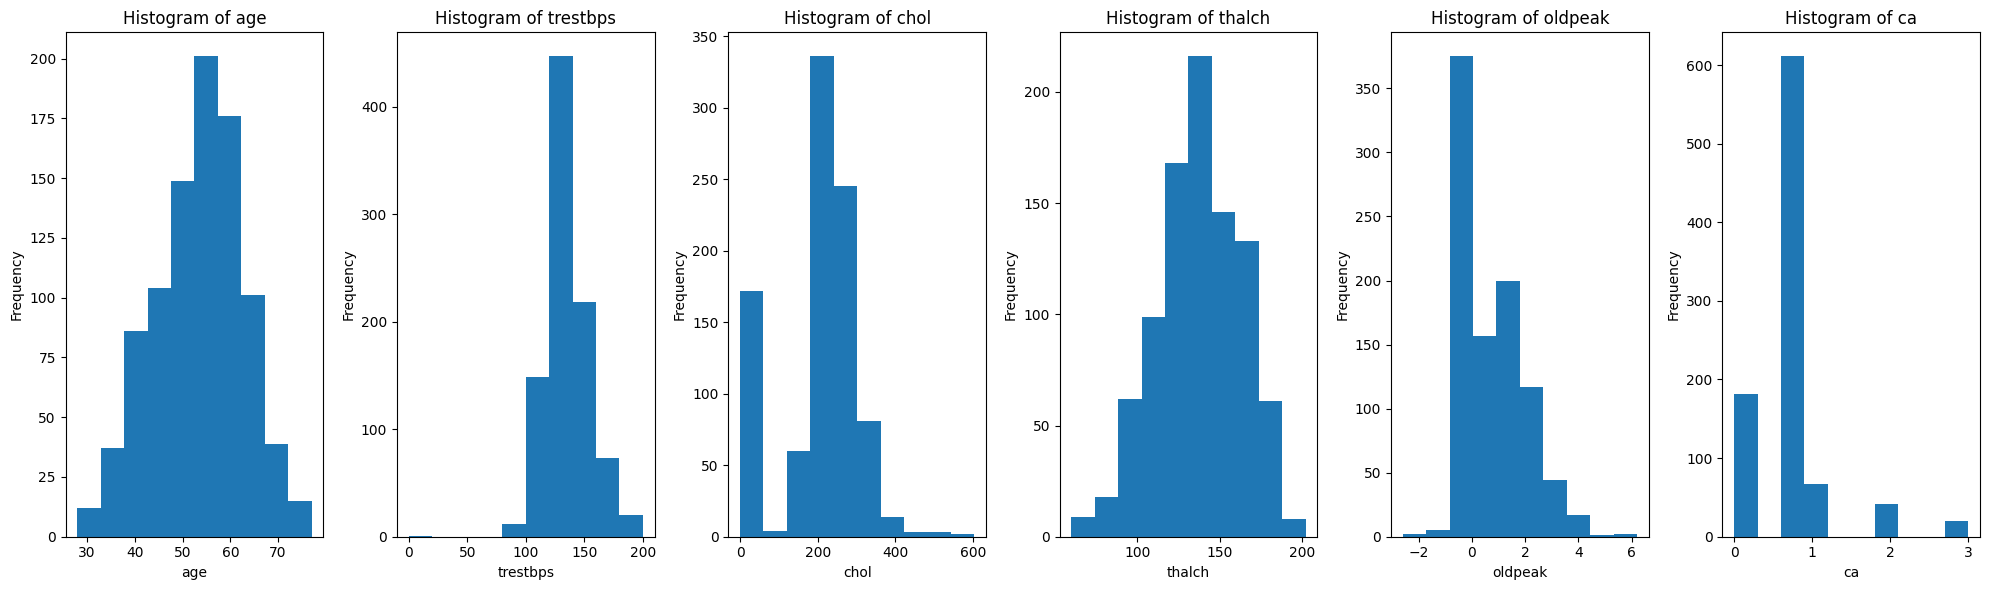

In [45]:
# plot histograms to view distribution of each numerical feature
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_features),
                         figsize=(20, 6))

for i in range(len(numerical_features)):
    axes[i].hist(df[numerical_features[i]])
    axes[i].set_title(f'Histogram of {numerical_features[i]}')
    axes[i].set_xlabel(numerical_features[i])
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [151]:
# transform categorical features using one-hot encoding so that they can be used in clustering algorithms
categorical_features = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
df_encoded = df.copy(deep=True)

df_encoded = pd.get_dummies(df, columns=categorical_features,
                                drop_first=True) # avoid multicollinearity

# remove irrelevant column: id
df_encoded.drop('id', axis=1, inplace=True)

In [152]:
df_encoded.head()

,age,trestbps,chol,thalch,oldpeak,ca,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,145.0,233.0,150.0,2.3,0.0,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,67,160.0,286.0,108.0,1.5,3.0,True,False,False,False,...,False,False,False,False,False,True,True,False,True,False
2,67,120.0,229.0,129.0,2.6,2.0,True,False,False,False,...,False,False,False,False,False,True,True,False,False,True
3,37,130.0,250.0,187.0,3.5,0.0,True,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4,41,130.0,204.0,172.0,1.4,0.0,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


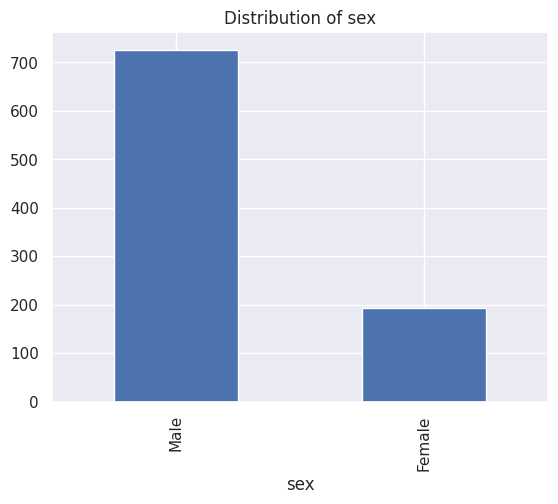

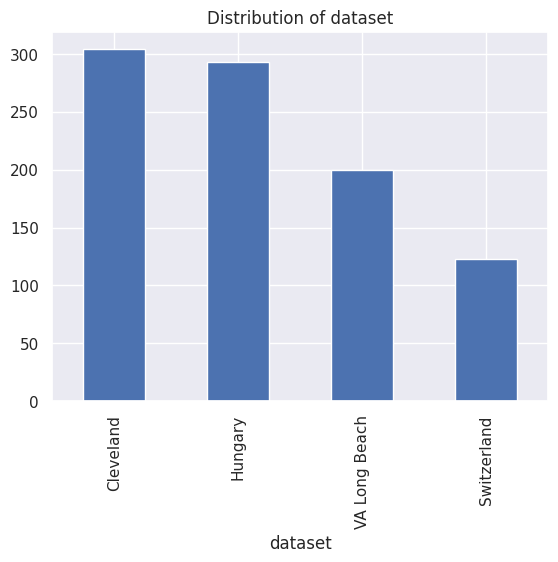

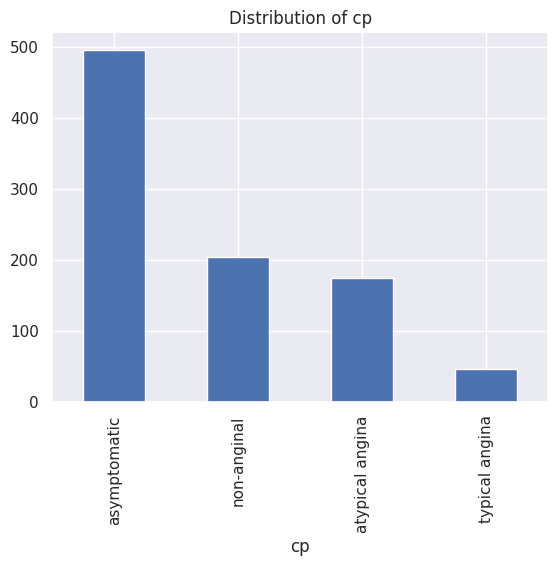

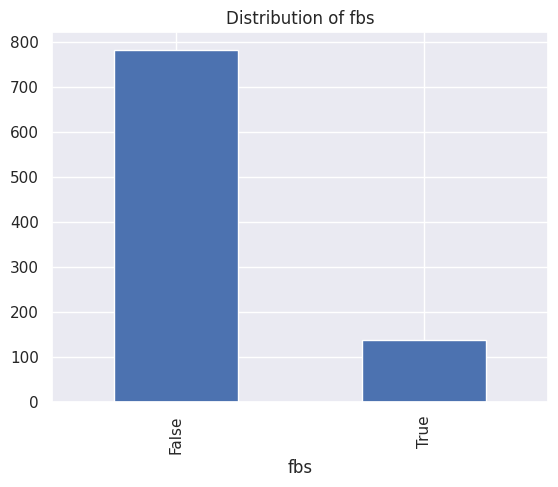

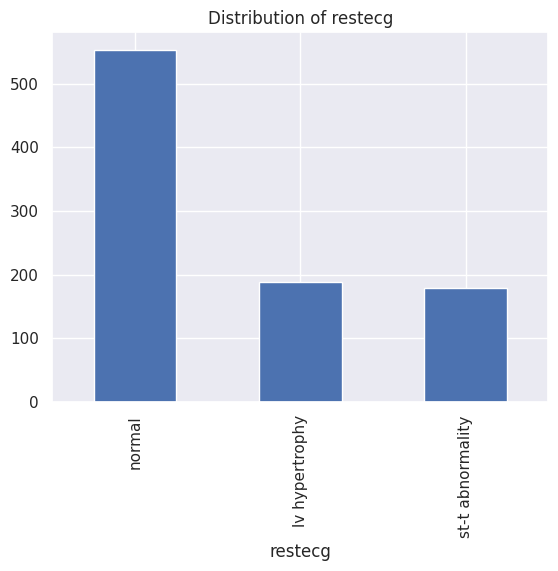

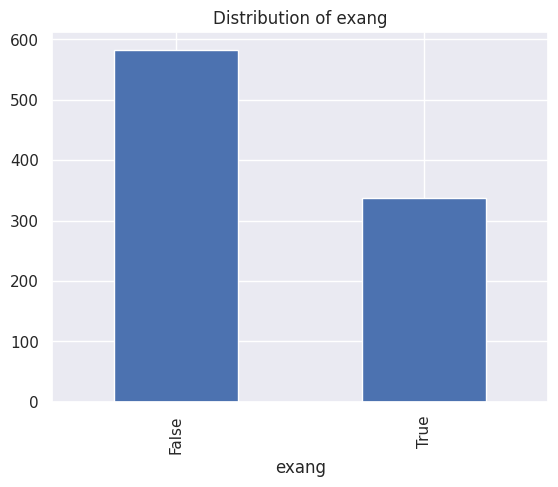

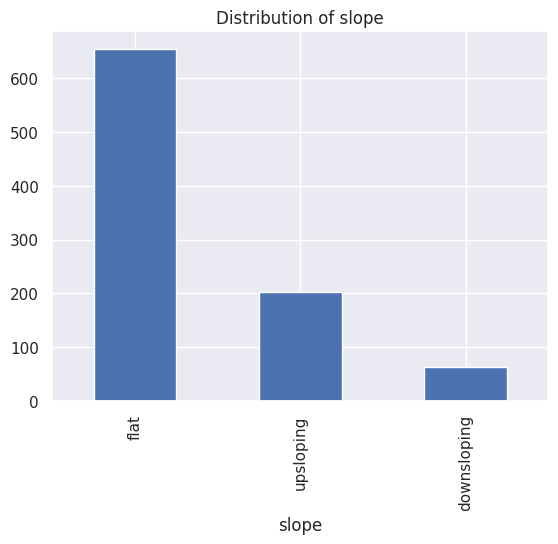

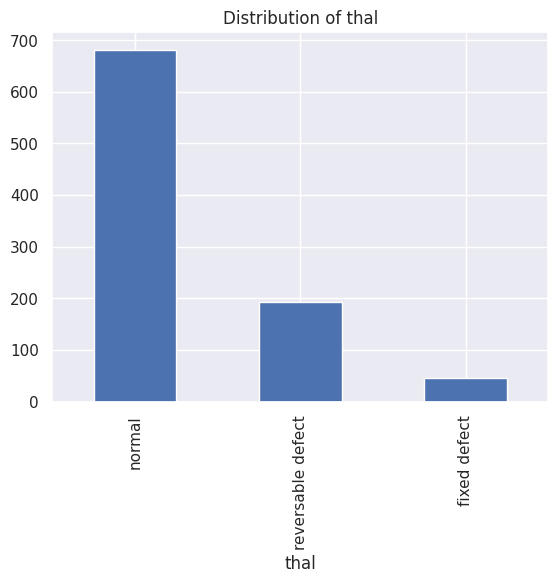

In [148]:
# plot histograms to view distribution of each categorical feature
categorical_features = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
sns.set(font_scale=1)
for i in range(len(categorical_features)):
    counts = df[categorical_features[i]].value_counts()
    counts.plot(kind='bar')
    plt.title(f'Distribution of {categorical_features[i]}')
    plt.xlabel(categorical_features[i])
    plt.show()

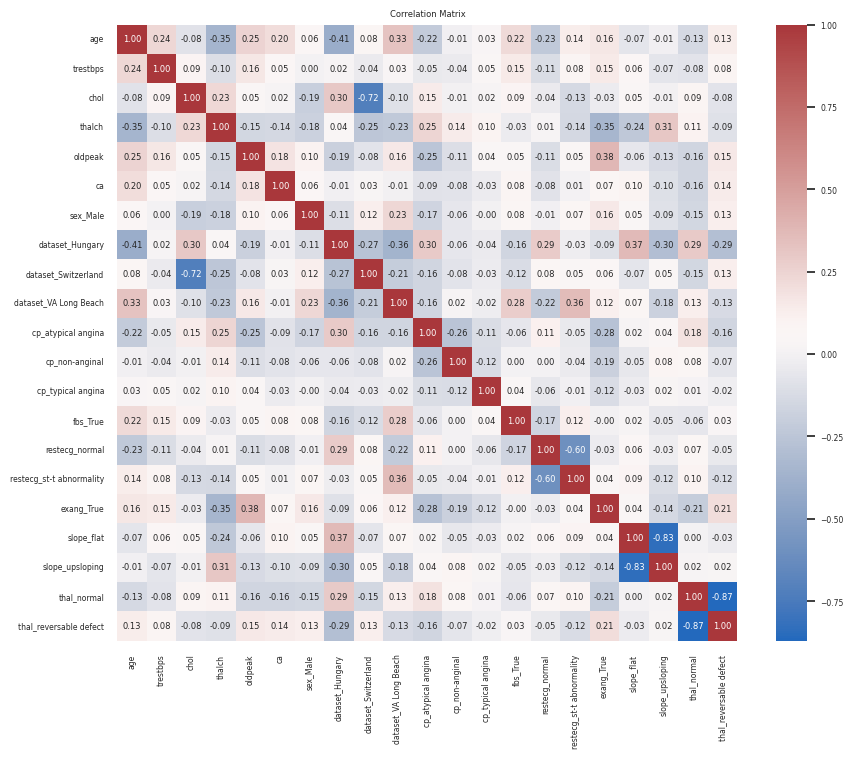

In [153]:
# view correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.2f', cmap='vlag')
sns.set(font_scale=0.5)
plt.title('Correlation Matrix')
plt.show()

**Observations**

There are unequal distribution of patients in the dataset, including:
* Unequal distribution of age in the dataset. Majority of the patients are > 40 years old.
* Disproportionate number of male patients compared to female patients.

These imbalanced class distributions suggest that the unsupervised clustering algorithm is more likely to be biased against the majority classes, thereby performing better on identifying majority vs minority groups.

Therefore, the model choices for unsuprvised learning will be to compare K Means and DBSCAN.
* K Means method clusters data based on a fixed number of classes, and using the nearest neighbor algorithm. If it turns out that the data is actually not unbalanced, this model will be effective and efficient as it is simple to train. However, because the number of classes is fixed, and the cluster center points are re-calculated based on distance, this may result in a model with significantly unbalanced classes.
* Therefore, the DBSCAN method will also be attempted, as it typically performs well on data with unbalanced classes. The DBSCAN method will be able to distinguish noise when clustering patients, and can identify clusters of irregular shapes, not just round shapes like in K Means.

There are a large number of features in the data. The dimensionality of the data should be reduced before training the model.

# Model Building and Training

**Feature Engineering**

Use PCA to reduce the dimensionality of the data, to make it easier to analyze.

In [154]:
pca = PCA(n_components=0.95) # use target explained variance ratio of 95%
df_pca = pca.fit_transform(df_encoded)
print("At a target variance ratio of 95%, the number of pca components are = ", pca.n_components_)

At a target variance ratio of 95%, the number of pca components are =  2


Text(0.5, 1.0, 'Cumulative explained variance ratio vs. No. of pca components')

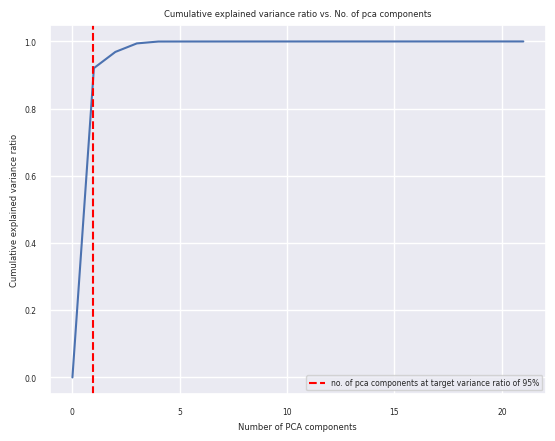

In [155]:
# visualize the selection of number of pca components, against all the possible target explained variance ratios
pca_all = PCA()
df_pca_all = pca_all.fit_transform(df_encoded)
plt.plot(range(0, pca_all.n_components_ + 1), [0] + list(pca_all.explained_variance_ratio_.cumsum()))
plt.axvline(x=pca.n_components, color='red', linestyle='--', label='no. of pca components at target variance ratio of 95%')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance ratio')
plt.legend()
plt.title('Cumulative explained variance ratio vs. No. of pca components')

**Model Option 1: K Means Model**

The clusters will be determined using the K Means method.
* Elbow method will be used to select the number of clusters for the K Means model
* Iterate to determine the best hyperparameters of the K Means model

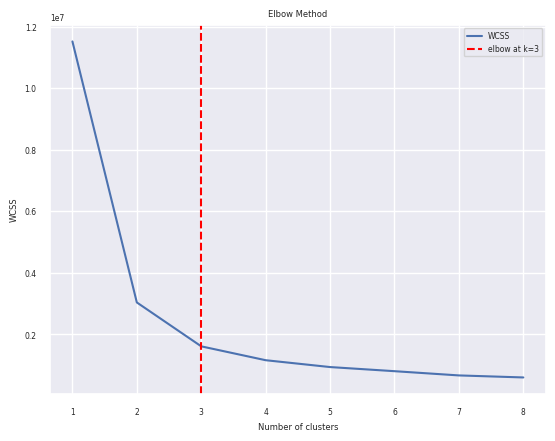

In [156]:
# K Means model requires to pre-determine the number of clusters needed
# Do this using the elbow method
# calculate within-cluster sum of squares (wcss), and plot wcss against number of clusters to determine where elbow is
wcss = []

for i in range(1, 9):
  tmp_model = KMeans(n_clusters=i, random_state=0, n_init="auto")
  tmp_model.fit(df_pca)
  wcss.append(tmp_model.inertia_)

# plot wcss
plt.plot(range(1, 9), wcss, label='WCSS')
plt.axvline(x=3, color='red', linestyle='--', label='elbow at k=3') # mark elbow of plot
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

Based on the elbow method, the number of clusters for K Means should be 3.

In [157]:
# Train K Means model
k = 3 # number of clusters determined via elbow method

# k means model hyperparameters are:
init_options = ['random', 'k-means++']
algorithm_options = ['lloyd', 'elkan']

# iteratively build and train model to determine the best hyperparameters
km_models = []
for init_ in init_options:
  for algorithm_ in algorithm_options:
    km_model = KMeans(n_clusters=k, init=init_, algorithm=algorithm_, random_state=0)
    km_model.fit(df_pca)
    km_models.append(km_model)

Accuracy score and confusion matrix metrics are not available as the data does not have ground truth labels to compare against.

Use visual assessment, to evaluate which model option hyperparameters are the most effective at clustering the patients. Additionally, use Silhouette score, which is a measure of the similarity between the clusters, to compare the hyperparameter options.

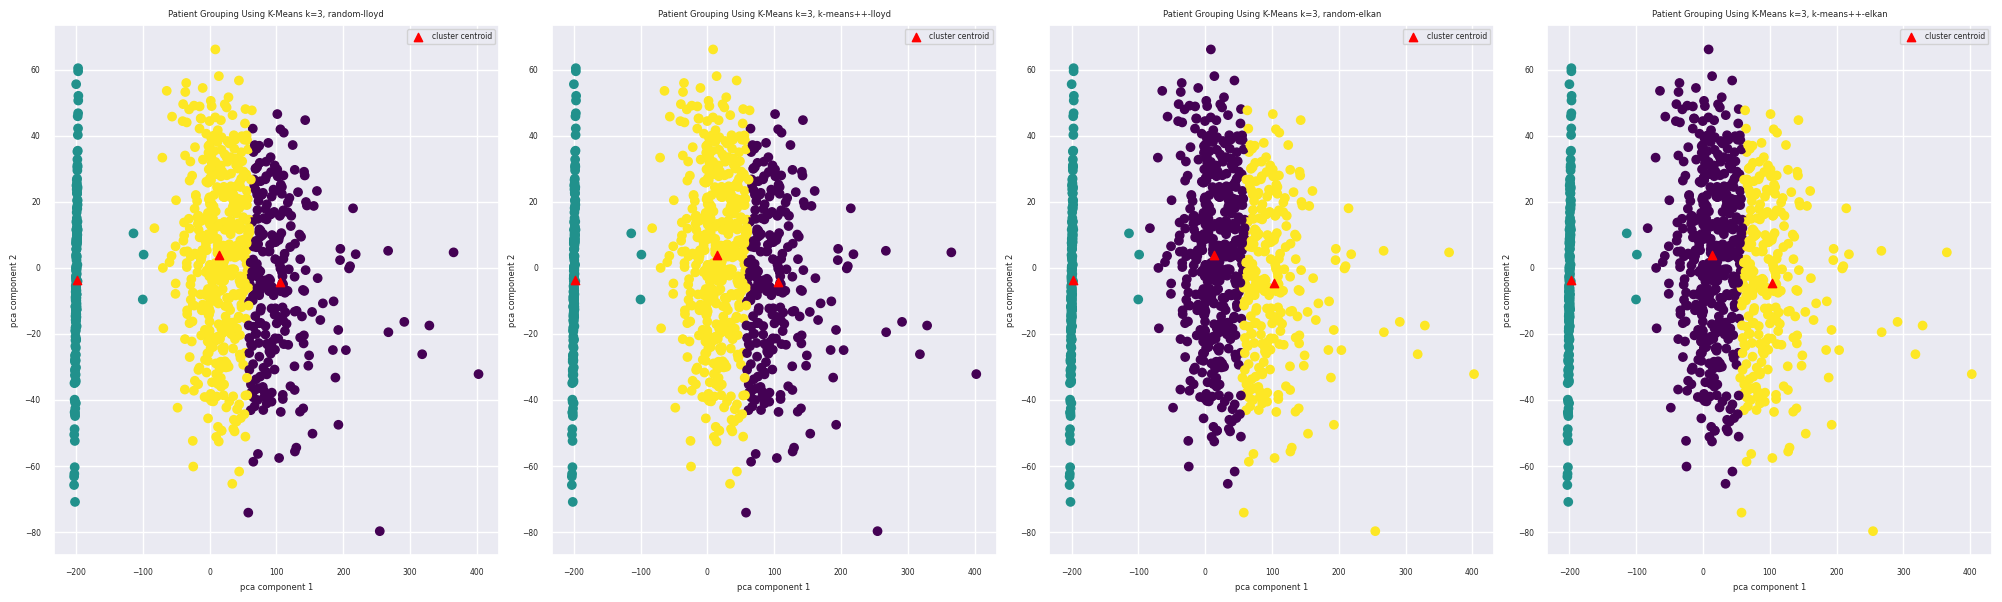

In [158]:
# create column for each model result
km_model_names = [ 'random-lloyd', 'k-means++-lloyd', 'random-elkan', 'k-means++-elkan']
silhouette_scores = []

# visualize each model cluster label to identify if clusters are well separated
fig, axes = plt.subplots(nrows=1, ncols=len(km_model_names),
                         figsize=(20, 6))
for i in range(len(km_model_names)):
    # plot patients, color-coded by their cluster
    labels = km_models[i].labels_
    axes[i].scatter(df_pca[:, 0], df_pca[:, 1], c=km_models[i].labels_, cmap='viridis')
    # calculate silhouette score
    silhouette_scores.append(silhouette_score(df_pca, labels))
    # plot cluster centroid
    centroid = km_models[i].cluster_centers_
    axes[i].scatter(centroid[:, 0], centroid[:, 1], marker='^', label='cluster centroid', color='red')
    axes[i].set_title(f'Patient Grouping Using K-Means k=3, {km_model_names[i]}')
    axes[i].set_xlabel('pca component 1')
    axes[i].set_ylabel('pca component 2')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [159]:
# compare silhouette score
for i in range(len(km_model_names)):
    print(f"Silhouette score for {km_model_names[i]}: {silhouette_scores[i]}")

Silhouette score for random-lloyd: 0.5310486592171496
Silhouette score for k-means++-lloyd: 0.5310486592171496
Silhouette score for random-elkan: 0.5298465366182543
Silhouette score for k-means++-elkan: 0.5298465366182543


**Observations**

Results show that the best K-means model is k = 3 with init_option k-means++, algorithm option lloyd, as it has the highest silhouette score.

Looking at the visual plots, there appears to be a only two clusters, one on the left and one to the right. Test if decreasing the k (number of clusters) to 2 will split out this group in a meaningful way

Silhouette score of k=2 is  0.7326392619003396


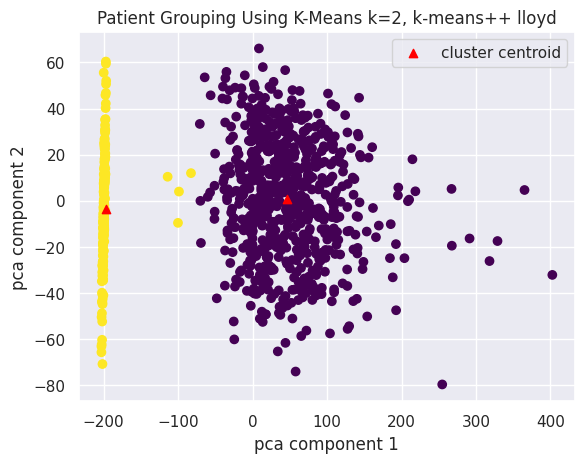

In [187]:
# Train K Means model with k = 2 and visualize results
km_model = KMeans(n_clusters=2, init='k-means++', algorithm='lloyd', random_state=0)
km_model.fit(df_pca)
sns.set(font_scale=1)

# plot patients, color-coded by their cluster
labels = km_model.labels_
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
# calculate silhouette score
print("Silhouette score of k=2 is ", silhouette_score(df_pca, labels))
# plot cluster centroid
centroid = km_model.cluster_centers_
plt.scatter(centroid[:, 0], centroid[:, 1], marker='^', label='cluster centroid', color='red')
plt.title(f'Patient Grouping Using K-Means k=2, k-means++ lloyd')
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.legend()
plt.show()

In [190]:
# save best kmeans model
best_km_model = KMeans(n_clusters=2, init='k-means++', algorithm='lloyd', random_state=0)
best_km_model.fit(df_pca)

KMeans(n_clusters=2, random_state=0)

**Analysis**

Observing that the silhouette score of k = 2 (0.7326392619003396) is better than best k = 3 model (0.5310486592171496). Therefore, reasonably conclude that for K-means, the k = 2 best model is the better model.

**Model Option 2: DBSCAN Model**

The clusters will be determined using the DBSCAN method.
* Elbow method will be used to select the eps for the DBSCAN model
* Iterate to determine the best hyperparameters of the DBSCAN model

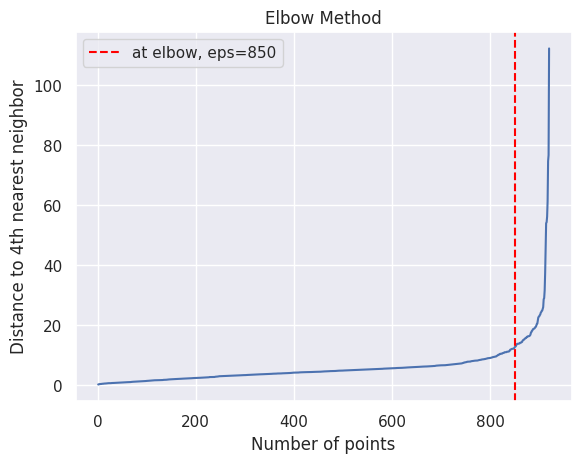

In [195]:
# Determine eps value using the elbow method
# Set minpts to 2 * number of pca components based on the general rule
minpts = 2 * df_pca.shape[1]

# calculate distances to kth nearest neighbor (where k = minpts)
neighbors = NearestNeighbors(n_neighbors=minpts + 1, metric='euclidean') # find the kth nearest neighbors, excluding the point itself
neighbors_fit = neighbors.fit(df_pca)

dist, ind = neighbors_fit.kneighbors(df_pca)
distances = dist[:, minpts]
distances.sort()

# plot distances to kth nearest neighbor against eps to determine where elbow is
plt.plot(np.arange(1, len(distances) + 1), distances)
plt.title('Elbow Method')
plt.xlabel('Number of points')
plt.ylabel(f"Distance to {minpts}th nearest neighbor")
plt.axvline(x=850, color='red', linestyle='--', label='at elbow, eps=850') # mark elbow of plot
plt.legend()

The elbow method to determine eps for DBSCAN does not appear to be an effective heuristic in this case, because the resulting eps is extremely large.

No silhouette score available, as the DBSCAN returned only one cluster


/tmp/ipython-input-328161458.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


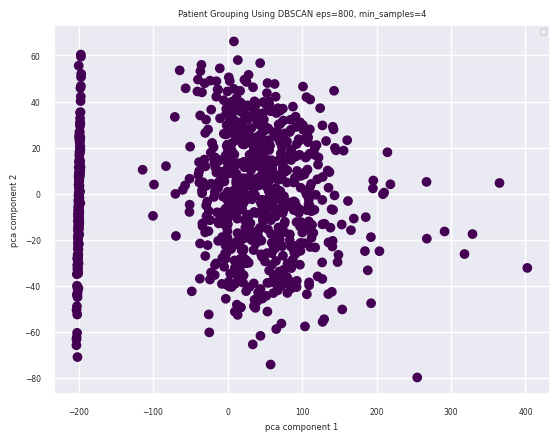

In [173]:
# Build DBSCAN model
dbscan_model = DBSCAN(eps=850, min_samples=minpts, metric='euclidean')
dbscan_labels = dbscan_model.fit_predict(df_pca)

# plot patients, color-coded by their cluster
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap='viridis')
# calculate silhouette score
try:
  print("Silhouette score of DBSCAN with eps=800, min_samples=,", minpts, " is ", silhouette_score(df_pca, dbscan_labels))
except:
  print("No silhouette score available, as the DBSCAN returned only one cluster")
plt.title(f"Patient Grouping Using DBSCAN eps=800, min_samples={minpts}")
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.legend()
plt.show()


DBSCAN was only able to identify one cluster.

Iteratively test other DBSCAN model options by decreasing the estimated eps (maximum distance to be considered a cluster) and adjusting the min_samples (minimum points to be considered a cluster) to determine if more clusters can be found.

Silhouette score of DBSCAN with eps= 80 , min_samples=, 2  is  0.7325419210731142


/tmp/ipython-input-1568068778.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


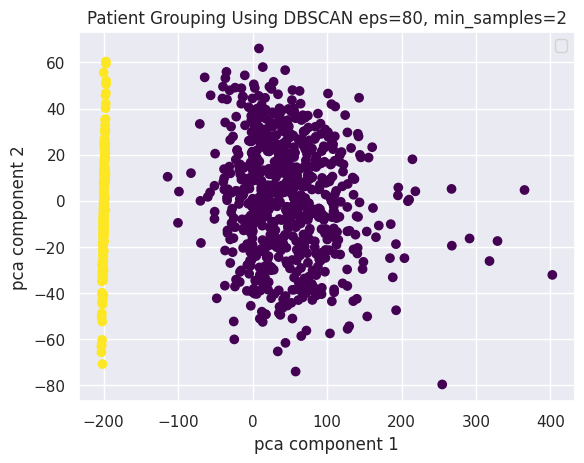

Silhouette score of DBSCAN with eps= 0.5 , min_samples=, 5  is  0.32147168094393774


/tmp/ipython-input-1568068778.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


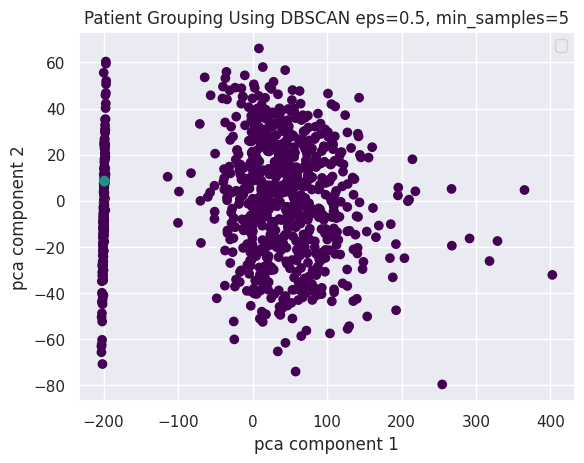

Silhouette score of DBSCAN with eps= 1e-12 , min_samples=, 1  is  0.004347826086956522


/tmp/ipython-input-1568068778.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


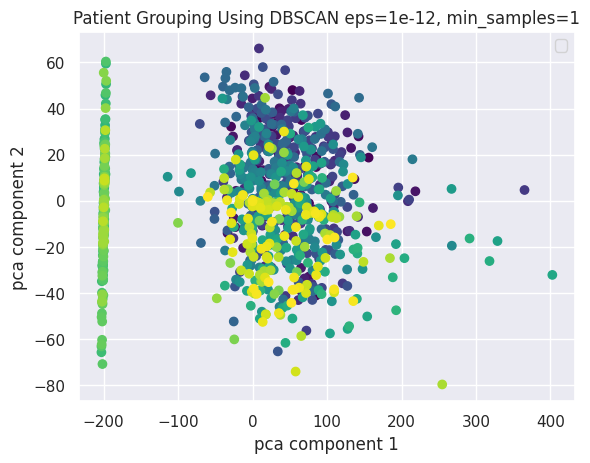

In [188]:
# Tune eps and min_samples hyperparameters on the DBSCAN model
eps_min_samples_options = ((80, 2), (0.5, 5), (0.000000000001, 1))

for options_ in eps_min_samples_options:
  eps = options_[0]
  minpts = options_[1]
  dbscan_model = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
  dbscan_labels = dbscan_model.fit_predict(df_pca)

  # plot patients, color-coded by their cluster
  plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap='viridis')
  # calculate silhouette score
  try:
    print("Silhouette score of DBSCAN with eps=", eps, ", min_samples=,", minpts, " is ", silhouette_score(df_pca, dbscan_labels))
  except:
    print("No silhouette score available, as the DBSCAN returned only one cluster")
  plt.title(f"Patient Grouping Using DBSCAN eps={eps}, min_samples={minpts}")
  plt.xlabel('pca component 1')
  plt.ylabel('pca component 2')
  plt.legend()
  plt.show()


In [191]:
# save best DBSCAN model
best_dbscan_model = DBSCAN(eps=80, min_samples=2, metric='euclidean')

**Analysis**

Comparing the silhouette score of the different hyperparameter options, the DBSCAN model with eps = 80, min_samples = 2 has the best silhouette score (0.7325419210731142). Therefore, it is the better DBSCAN model.

# Summary of Results

The results are evaluated by comparing:
* Model silhouette score
* Model performance on test data

In [193]:
# generate files for submission to Kaggle to evaluate performance on test dataset
test_ids = pd.read_csv('sample.csv')['id']
predictions = [best_km_model.labels_, best_dbscan_model.fit_predict(df_pca)]

for i in range(len(predictions)):
  submission_csv = pd.DataFrame(df['id'])
  submission_csv['cluster'] = predictions[i]
  # filter out ids that are not in test_ids
  submission_csv = submission_csv[submission_csv['id'].isin(test_ids)]
  submission_csv.to_csv('submission'+str(i)+'.csv', index=False)


The test data log loss results are:
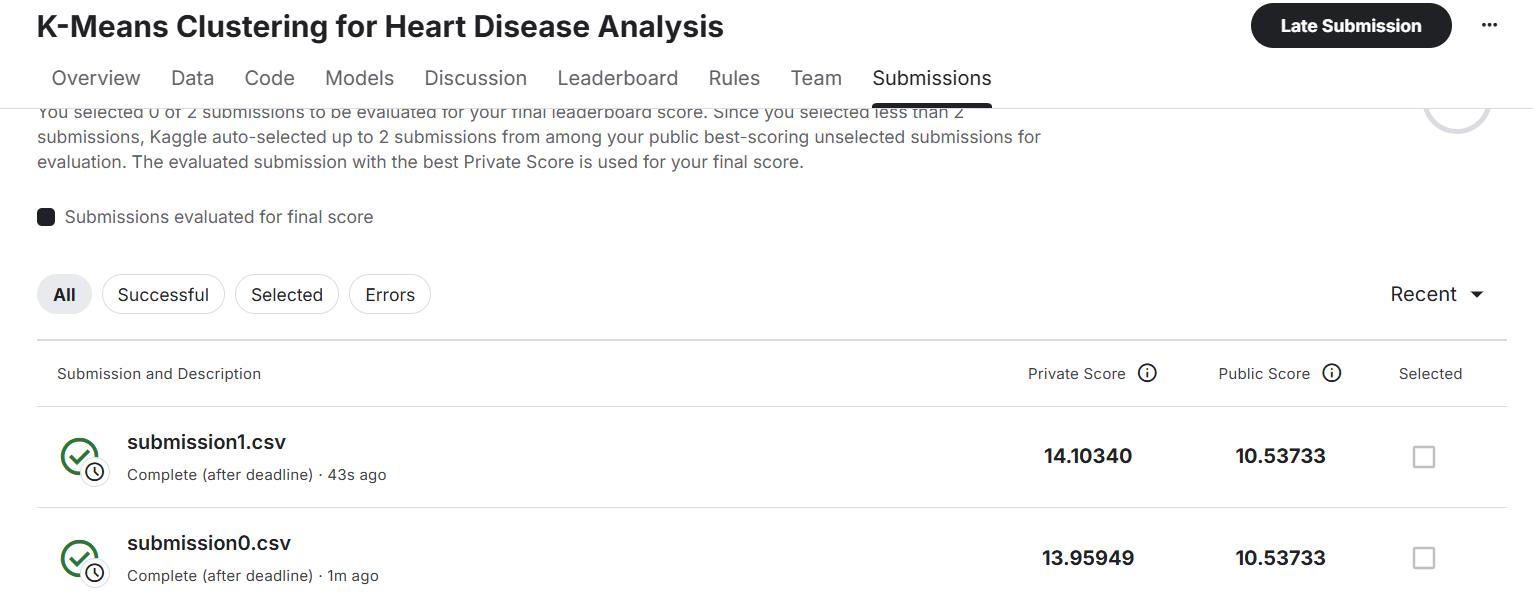

Visualizing the model results in a table:

| Model Option | Additional Hyperparameters Applied | Silhouette Score (higher the better quality of cluster) | Test Log Loss Score (lower loss is better)
| --- | --- | --- | --- |
| Kmeans | k=3, k-means++ init and llyod algorithm | 0.5310486592171496 |
| Kmeans | k=2, k-means++ init and llyod algorithm | 0.7326392619003396 | 13.95949
| DBSCAN | eps=850, min_samples=4 | N/A, only one cluster |
| DBSCAN | eps= 1e-12 , min_samples=1 | 0.004347826086956522 |
| DBSCAN | eps= 0.5 , min_samples=5| 0.32147168094393774 |
| DBSCAN | eps=80, min_samples=2   | 0.7325419210731142 | 14.10340

Comparing between the models, when the model detects 2 clusters, the cluster quality is the best.

Overall, the DBSCAN method (approx 0.7325 silhouette score) performs slightly worse than the Kmeans method  (approx 0.7326 silhouette score). The log loss score evaluated from Kaggle is also lower for the Kmeans method.


---


# Conclusion

The poor model performance when the DBSCAN uses the eps value from the elbow method is likely due to the patient datapoints being more scattered in the space, making it difficult for the nearest-kth neighbor distance to be an effective heurstic for eps. Instead, looking at the data visually was more effective, however it is potentially biased as it is determined based on the human eye judgement.

Between the two different regression models, the best K-means regression model of degree 2 performs slighlty better than the best DBSCAN regression model. As shown in the results, PCA feature engineering, hyperparameter tuning on the number of clusters, eps, min_samples, and other parameters helped improve the performance of the models.
A key takeaway is that results from unsupervised learning performed on unlabeled data can be evaluated visually and using metrics such as the silhouette metric to evaluate the quality of the clusters.

To improve the performance of the model, the following next steps can be considered:
* Augment the dataset with additional features of higher correlation to learn. This can be achieved by using additional external sources that have additional data on patients with heart disease diagnosis. By incorporating more useful data and features, this can enhance the model's ability to generalize in the real world.
* Explore alternative methods of dimensionality reduction that could be more effective.
* Further tune additional hyperparameters in the DBSCAN model, and test out additional heurstic methods and other methods to determine a suitable eps and min_samples value to use.

# References
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* https://scikit-learn.org/stable/modules/clustering.html
* https://medium.com/@zalarushirajsinh07/the-elbow-method-finding-the-optimal-number-of-clusters-d297f5aeb189
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
* https://www.datacamp.com/tutorial/dbscan-clustering-algorithm
